In [1]:
!conda info --envs

# conda environments:
#
base                     /home/kkh/anaconda3
BertT                    /home/kkh/anaconda3/envs/BertT
KD                    *  /home/kkh/anaconda3/envs/KD
msa                      /home/kkh/anaconda3/envs/msa



In [1]:
import sys
import keras as k
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets

print(sys.version)
print(tf.__version__)

Using TensorFlow backend.


3.7.5 (default, Oct 25 2019, 15:51:11) 
[GCC 7.3.0]
2.0.0


In [2]:
from keras.preprocessing.image import ImageDataGenerator

(train_x, train_y), (test_x, test_y) = datasets.cifar10.load_data()
datagen = ImageDataGenerator(rotation_range = 15,horizontal_flip = True, vertical_flip= True, width_shift_range= 0.1, height_shift_range= 0.1, zoom_range = 0.1)
datagen.fit(train_x)
train_x=train_x.astype("float32")  
test_x=test_x.astype("float32")
mean=np.mean(train_x)
std=np.std(train_x)
test_x=(test_x-mean)/std
train_x=(train_x-mean)/std

# labels
num_classes=10
train_y = k.utils.to_categorical(train_y, num_classes)
test_y = k.utils.to_categorical(test_y, num_classes)

In [3]:
import cv2
import os
import keras as k
trainX = []
trainY = []
train_path = './downsized/train/'
train = os.listdir(train_path)
for i in range(len(train)):
    files = sorted(os.listdir(train_path+train[0]))
    for j in range(20):
        img = cv2.imread(train_path+train[i]+'/'+files[j])
        img = cv2.resize(img,dsize=(32,32))
        trainX.append(img)
        trainY.append(i)

testX = []
testY = []
test_path = './downsized/test/'
test = os.listdir(test_path)
for i in range(len(test)):
    files = sorted(os.listdir(test_path+test[0]))
    for j in range(10):
        img = cv2.imread(test_path+test[i]+'/'+files[j])
        img = cv2.resize(img,dsize=(32,32))
        testX.append(img)
        testY.append(i)
        
        

import numpy as np
trainX = np.array(trainX).reshape(-1,32,32,3)
testX = np.array(testX).reshape(-1,32,32,3)

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range = 15,horizontal_flip = True, vertical_flip= True, width_shift_range= 0.1, height_shift_range= 0.1, zoom_range = 0.1)
datagen.fit(trainX)
trainX=trainX.astype("float32")  
testX=testX.astype("float32")
mean=np.mean(trainX)
std=np.std(trainX)
testX=(testX-mean)/std
trainX=(trainX-mean)/std

trainY = np.array(trainY)
testY = np.array(testY)
trainY = k.utils.to_categorical(trainY, 100)
testY = k.utils.to_categorical(testY, 100)

In [4]:
import matplotlib.pyplot as plt
# plotting helper function
def plothist_acc(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [5]:
# plotting helper function
def plothist_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [6]:
from tensorflow.keras.models import load_model
model = load_model('teacher.h5')

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 34, 34, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928 

In [8]:
from tensorflow import keras
from tensorflow.keras.layers import Lambda, Activation
oldmodel = keras.Model(model.input,model.layers[-1].output)
oldmodel.trainable=False

Temperature = 10

T_layer = Lambda(lambda x:x/Temperature)(oldmodel.output)
Softmax_layer = Activation('softmax')(T_layer)
soften = keras.Model(model.input,Softmax_layer)

soft_label = soften.predict(trainX)
soft_label_test = soften.predict(testX)

new_train_y = np.concatenate([trainY,soft_label],axis=1)
new_test_y = np.concatenate([testY,soft_label_test],axis=1)

DenseForNew = Dense(100,name='dense_10')(oldmodel.layers[-2].output)
output_new = Activation('softmax')(DenseForNew)
warmupModel = keras.Model(model.input,output_new)

adam = Adam(learning_rate = 0.0001, beta_1=0.9, beta_2=0.999)
early_stopping = EarlyStopping(monitor='val_accuracy',patience=20,mode='auto',restore_best_weights=True)
warmupModel.compile(optimizer= adam,loss='categorical_crossentropy',metrics=['accuracy'])
history = warmupModel.fit(trainX,trainY,epochs=200,validation_data=(testX,testY),callbacks=[early_stopping],batch_size=8,shuffle=True)

In [9]:
oldmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 34, 34, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928 

In [10]:
new_train_y = np.concatenate([trainY,soft_label],axis=1)
new_test_y = np.concatenate([testY,soft_label_test],axis=1)

In [11]:
from tensorflow.keras.layers import Dense
DenseForNew = Dense(100,name='dense_10')(oldmodel.layers[-2].output)
output_new = Activation('softmax')(DenseForNew)
warmupModel = keras.Model(model.input,output_new)

In [12]:
warmupModel.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 34, 34, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        3692

In [13]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
adam = Adam(learning_rate = 0.00001, beta_1=0.9, beta_2=0.999)
early_stopping = EarlyStopping(monitor='val_accuracy',patience=20,mode='auto',restore_best_weights=True)
warmupModel.compile(optimizer= adam,loss='categorical_crossentropy',metrics=['accuracy'])
history = warmupModel.fit(trainX,trainY,epochs=200,validation_data=(testX,testY),callbacks=[early_stopping],batch_size=8,shuffle=True)

Train on 2000 samples, validate on 1000 samples
Epoch 1/200
2000/2000 [==============================] - 4s 2ms/sample - loss: 5.0337 - accuracy: 0.0090 - val_loss: 4.6642 - val_accuracy: 0.0080
Epoch 2/200
2000/2000 [==============================] - 2s 1ms/sample - loss: 4.9572 - accuracy: 0.0100 - val_loss: 4.6434 - val_accuracy: 0.0100
Epoch 3/200
2000/2000 [==============================] - 2s 1ms/sample - loss: 4.8768 - accuracy: 0.0125 - val_loss: 4.6275 - val_accuracy: 0.0080
Epoch 4/200
2000/2000 [==============================] - 2s 1ms/sample - loss: 4.8658 - accuracy: 0.0130 - val_loss: 4.6147 - val_accuracy: 0.0120
Epoch 5/200
2000/2000 [==============================] - 2s 1ms/sample - loss: 4.8290 - accuracy: 0.0125 - val_loss: 4.6039 - val_accuracy: 0.0140
Epoch 6/200
2000/2000 [==============================] - 2s 1ms/sample - loss: 4.8160 - accuracy: 0.0130 - val_loss: 4.5947 - val_accuracy: 0.0140
Epoch 7/200
2000/2000 [==============================] - 2s 1ms/sample

2000/2000 [==============================] - 2s 1ms/sample - loss: 4.4911 - accuracy: 0.0385 - val_loss: 4.4636 - val_accuracy: 0.0350
Epoch 57/200
2000/2000 [==============================] - 2s 1ms/sample - loss: 4.5083 - accuracy: 0.0250 - val_loss: 4.4623 - val_accuracy: 0.0330
Epoch 58/200
2000/2000 [==============================] - 2s 1ms/sample - loss: 4.4956 - accuracy: 0.0330 - val_loss: 4.4621 - val_accuracy: 0.0330
Epoch 59/200
2000/2000 [==============================] - 2s 1ms/sample - loss: 4.4891 - accuracy: 0.0385 - val_loss: 4.4614 - val_accuracy: 0.0350
Epoch 60/200
2000/2000 [==============================] - 2s 1ms/sample - loss: 4.4777 - accuracy: 0.0370 - val_loss: 4.4605 - val_accuracy: 0.0330
Epoch 61/200
2000/2000 [==============================] - 2s 1ms/sample - loss: 4.4697 - accuracy: 0.0405 - val_loss: 4.4597 - val_accuracy: 0.0340
Epoch 62/200
2000/2000 [==============================] - 2s 1ms/sample - loss: 4.4696 - accuracy: 0.0340 - val_loss: 4.4589 

In [15]:
warmupModel.save('warmup.h5')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras.layers import Lambda, Activation,Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
warmupModel = load_model('warmup.h5')

In [14]:
from tensorflow.keras.layers import concatenate

warmupModel.trainable = True
old_output = Activation('softmax',name="old_activation")(oldmodel.layers[-1].output)

combined_layer = concatenate([warmupModel.output,old_output])
combined_model = keras.Model(warmupModel.input,combined_layer)
for layer in combined_model.layers:
    if layer.name.startswith('conv2d'):
        layer.kernel_regularizer = keras.regularizers.l2(0.0005)
        

In [15]:
for layer in combined_model.layers:
    if layer.name.startswith('conv2d'):
        layer.kernel_regularizer = keras.regularizers.l2(0.0005)
        print("Clear!")

Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here


In [16]:
combined_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 34, 34, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
____________________________________________________________________________________________

In [17]:
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.losses import kullback_leibler_divergence as KLD_Loss, categorical_crossentropy as logloss

def LWF_loss(y_true,y_pred,lambd=0.1,T=2):
    y_true,y_true_lwf = y_true[:,:100],y_true[:,100:]
    y_pred,y_pred_lwf = y_pred[:,:100],y_pred[:,100:]
    # Classic cross-entropy (without temperature) hard target
    new_loss = logloss(y_true,y_pred)
    # KL-Divergence loss for softened output (with temperature) soft target Loss_Teacher
    old_loss = KLD_Loss(y_true_lwf,y_pred_lwf)

    return lambd*old_loss + new_loss

def accuracy(y_true,y_pred):
    return categorical_accuracy(y_true,y_pred)

In [18]:
adam = Adam(learning_rate = 0.00001, beta_1=0.9, beta_2=0.999)
combined_model.compile(optimizer= adam,loss=lambda y_true,y_pred: LWF_loss(y_true, y_pred,lambd=0.8,T=10),metrics=['accuracy'])
history = combined_model.fit(trainX,new_train_y,epochs=200,validation_data=(testX,new_test_y),batch_size=32,shuffle=True)

Train on 2000 samples, validate on 1000 samples
Epoch 1/200
2000/2000 [==============================] - 5s 3ms/sample - loss: 4.5278 - accuracy: 0.0010 - val_loss: 4.4343 - val_accuracy: 0.0000e+00
Epoch 2/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 4.4414 - accuracy: 0.0025 - val_loss: 4.3822 - val_accuracy: 0.0000e+00
Epoch 3/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 4.4036 - accuracy: 0.0035 - val_loss: 4.3369 - val_accuracy: 0.0020
Epoch 4/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 4.3902 - accuracy: 0.0035 - val_loss: 4.3035 - val_accuracy: 0.0020
Epoch 5/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 4.3499 - accuracy: 0.0020 - val_loss: 4.2678 - val_accuracy: 0.0030
Epoch 6/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 4.3057 - accuracy: 0.0035 - val_loss: 4.2342 - val_accuracy: 0.0060
Epoch 7/200
2000/2000 [==============================] - 3s 1m

2000/2000 [==============================] - 3s 1ms/sample - loss: 2.8937 - accuracy: 0.1735 - val_loss: 3.5838 - val_accuracy: 0.1360
Epoch 57/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 2.8357 - accuracy: 0.2090 - val_loss: 3.5685 - val_accuracy: 0.1420
Epoch 58/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 2.8278 - accuracy: 0.1900 - val_loss: 3.5913 - val_accuracy: 0.1400
Epoch 59/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 2.7981 - accuracy: 0.1975 - val_loss: 3.5879 - val_accuracy: 0.1440
Epoch 60/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 2.7743 - accuracy: 0.2075 - val_loss: 3.5653 - val_accuracy: 0.1560
Epoch 61/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 2.7890 - accuracy: 0.2050 - val_loss: 3.5675 - val_accuracy: 0.1510
Epoch 62/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 2.7571 - accuracy: 0.2105 - val_loss: 3.5795 

2000/2000 [==============================] - 3s 1ms/sample - loss: 1.8093 - accuracy: 0.4555 - val_loss: 3.7397 - val_accuracy: 0.2370
Epoch 112/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 1.7827 - accuracy: 0.4820 - val_loss: 3.7626 - val_accuracy: 0.2330
Epoch 113/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 1.8030 - accuracy: 0.4575 - val_loss: 3.7455 - val_accuracy: 0.2360
Epoch 114/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 1.7527 - accuracy: 0.4850 - val_loss: 3.7581 - val_accuracy: 0.2340
Epoch 115/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 1.7551 - accuracy: 0.4875 - val_loss: 3.7889 - val_accuracy: 0.2310
Epoch 116/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 1.7031 - accuracy: 0.4920 - val_loss: 3.7983 - val_accuracy: 0.2390
Epoch 117/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 1.7436 - accuracy: 0.4760 - val_loss: 3

2000/2000 [==============================] - 3s 1ms/sample - loss: 1.0976 - accuracy: 0.6660 - val_loss: 4.1713 - val_accuracy: 0.2800
Epoch 167/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 1.0428 - accuracy: 0.6960 - val_loss: 4.2084 - val_accuracy: 0.2730
Epoch 168/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 1.1147 - accuracy: 0.6755 - val_loss: 4.2535 - val_accuracy: 0.2730
Epoch 169/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 1.1150 - accuracy: 0.6575 - val_loss: 4.2209 - val_accuracy: 0.2740
Epoch 170/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 1.0889 - accuracy: 0.6800 - val_loss: 4.2221 - val_accuracy: 0.2730
Epoch 171/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 1.0318 - accuracy: 0.6985 - val_loss: 4.2268 - val_accuracy: 0.2760
Epoch 172/200
2000/2000 [==============================] - 3s 1ms/sample - loss: 1.0581 - accuracy: 0.6975 - val_loss: 4

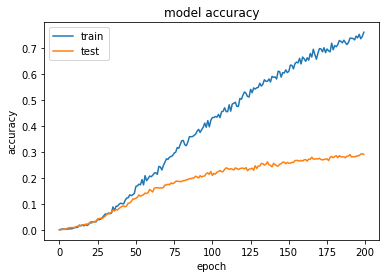

In [19]:
plothist_acc(history)

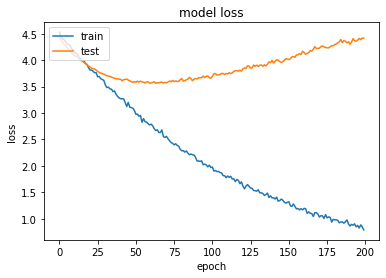

In [20]:
plothist_loss(history)

In [21]:
combined_model.evaluate(testX,new_test_y)

1000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[4.4156144971847535, 0.291]

In [22]:
combined_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 34, 34, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
____________________________________________________________________________________________

In [28]:
oldModel.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 34, 34, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        369

In [30]:
oldOutput = keras.Model(combined_model.input,combined_model.layers[-6].output)
oldOutput.trainable=False
DenseL = Dense(10,name='dense_10')(oldOutput.output)
SoftmaxLayer = Activation('softmax')(DenseL)
oldModel = keras.Model(oldOutput.input,SoftmaxLayer)
adam = Adam(learning_rate = 0.00001, beta_1=0.9, beta_2=0.999)
oldModel.compile(optimizer= adam,loss='categorical_crossentropy',metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy',patience=10,mode='auto',restore_best_weights=True)
history = oldModel.fit(train_x,train_y,epochs=200,validation_data=(test_x,test_y),callbacks=[early_stopping],batch_size=8,shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 48s 968us/sample - loss: 0.9717 - accuracy: 0.6903 - val_loss: 1.3378 - val_accuracy: 0.6838
Epoch 2/200
50000/50000 [==============================] - 47s 943us/sample - loss: 0.7201 - accuracy: 0.7720 - val_loss: 1.3902 - val_accuracy: 0.6881
Epoch 3/200
50000/50000 [==============================] - 47s 943us/sample - loss: 0.7099 - accuracy: 0.7758 - val_loss: 1.4032 - val_accuracy: 0.6909
Epoch 4/200
50000/50000 [==============================] - 47s 944us/sample - loss: 0.6956 - accuracy: 0.7770 - val_loss: 1.3833 - val_accuracy: 0.6937
Epoch 5/200
50000/50000 [==============================] - 47s 942us/sample - loss: 0.6877 - accuracy: 0.7789 - val_loss: 1.4187 - val_accuracy: 0.6909
Epoch 6/200
50000/50000 [==============================] - 47s 943us/sample - loss: 0.6925 - accuracy: 0.7777 - val_loss: 1.4087 - val_accuracy: 0.6936
Epoch 7/200
50000/50000 [=============